# 0. Setup


In [ ]:
import numpy as np
import pandas as pd
import torchvision
from torchvision import transforms, datasets, models
import torch
from PIL import Image
from pathlib import Path
from bs4 import BeautifulSoup
import os
import io
import cv2
import torch.nn.functional as F

# 1. Check is GPU available

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
  print("GPU is available")
else:
  print("GPU is not available")

GPU is available


# 2. Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

root = '/gdrive/My Drive/CS470/Project/dataset'

Mounted at /gdrive


# 3. Define datasets

In [ ]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __getitem__(self, idx):
        folder=idx // 1000
        num= idx % 1000
        folder_name = 'data'+str(folder)

        file_list=list(sorted(os.listdir(Path(root)/folder_name)))
        file_name=file_list[num]
        img_path = os.path.join(Path(root)/folder_name,file_name)

        img=Image.open(img_path).convert("RGB")

        #~~~~~~.jpg                       0 ; without mask
        #00001_Mask.jpg                   1
        #00001_Mask_Chin.jpg.             2
        #00001_Mask_Mouth_Chin.jpg        3
        #00001_Mask_Nose_Mouth.jpg        4

        p_list=str(file_name).split('_')
        if len(p_list)==1:
          label=0
        elif len(p_list)==2:
          label=1
        elif len(p_list)==3:
          label=2
        elif p_list[-1]=='Chin.jpg':
          label=3
        else:
          label=4
          
        #Generate Label
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, label

    def __len__(self):
        return 39000


# 4. Build dataloader and transform

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = MaskDataset(preprocess)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=256, shuffle=True)

In [ ]:
import cv2

print('size of train datasets :',len(train_loader.dataset))
print('size of test datasets  :',len(test_loader.dataset))

size of train datasets : 31200
size of test datasets  : 7800


# 5. Define model

In [ ]:
model = torchvision.models.mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=5)
model.eval()
model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
from torch.utils.mobile_optimizer import optimize_for_mobile

# name should be a string ex) model.pt
def model_save(model, name):
    t_model = torch.jit.trace(model, torch.rand(1,3,224,224).to(device))
    torch.jit.save(t_model, "/gdrive/My Drive/CS470/Project/"+"scripted_"+name)
    q_model = torch.quantization.convert(model)
    traced_script_module = torch.jit.trace(q_model, torch.rand(1,3,224,224).to(device))
    opt_model = optimize_for_mobile(traced_script_module)
    torch.jit.save(opt_model, "/gdrive/My Drive/CS470/Project/"+"quantized_" + name)

# 6. Training

In [ ]:
# pre-setup
num_epochs = 20
params = [p for p in model.parameters() if p.requires_grad]
learning_rate = 0.0005
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.000001)
loss_func = torch.nn.CrossEntropyLoss().to(device)

In [ ]:
# for plotting
from matplotlib import pyplot as plt
train_loss_list = []
test_loss_list = []

In [ ]:
for epoch in range(num_epochs):
  epoch_loss = 0
  test_loss = 0
  best_test_loss = 1

  for i, samples in enumerate(train_loader):
      model.train()
      imgs, annotations = samples
      imgs, annotations = imgs.to(device), annotations.to(device)
      
      output = model(imgs)
      loss = loss_func(output,annotations)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print(f'Iteration: {i+1}/{len(train_loader)}, Loss: {loss.item()}')
      epoch_loss += loss.item()

  avg_train_loss = epoch_loss/len(train_loader)

  # Save result for plotting
  train_loss_list.append(avg_train_loss)

  # Print epoch's test loss
  print(f'Epoch {epoch} train loss: {avg_train_loss}')

  # validation
  for i,test_samples in enumerate(test_loader):
    with torch.no_grad():
      model.eval()
      test_imgs, test_annotations = test_samples
      test_imgs, test_annotations = test_imgs.to(device), test_annotations.to(device)

      test_output = model(test_imgs)
      loss = loss_func(test_output, test_annotations)
      test_loss += loss.item()

      # print(f'Iteration: {i+1}/{len(test_loader)}, Loss: {loss.item()}')
  
  avg_test_loss = test_loss/len(test_loader)

  # Save result for plotting
  test_loss_list.append(avg_test_loss)

  # Print epoch's test loss
  print(f'Epoch {epoch} test loss: {avg_test_loss}')

  # save best
  if best_test_loss > avg_test_loss:
    best_test_loss = avg_test_loss
    model_save(model, 'best.pt')

  print('-------------------------------------')

Iteration: 1/122, Loss: 0.015347171574831009
Iteration: 2/122, Loss: 0.00937697198241949
Iteration: 3/122, Loss: 0.013332911767065525
Iteration: 4/122, Loss: 0.003067067824304104
Iteration: 5/122, Loss: 0.00811020378023386
Iteration: 6/122, Loss: 0.00820335652679205
Iteration: 7/122, Loss: 0.011796793900430202
Iteration: 8/122, Loss: 0.0036013724748045206
Iteration: 9/122, Loss: 0.00516414362937212
Iteration: 10/122, Loss: 0.010098299942910671
Iteration: 11/122, Loss: 0.004660594742745161
Iteration: 12/122, Loss: 0.00975316297262907
Iteration: 13/122, Loss: 0.0064908890053629875
Iteration: 14/122, Loss: 0.0027525241021066904
Iteration: 15/122, Loss: 0.005461301188915968


KeyboardInterrupt: ignored

[0.5707498230650777, 0.13997720267440453, 0.07168852583673156, 0.050325374073180995, 0.03912132315062841, 0.032139985043494426, 0.02776302856042004, 0.02506308903780262, 0.02239607078343874, 0.0209333337518982, 0.019588742886105032, 0.017646326483074636, 0.016012572003986505, 0.015206075630333946, 0.014002247816562409, 0.013208354796573032, 0.012806835876335009, 0.012207672820563932, 0.011545140052893673, 0.011008123744118836]
[0.20948123643475194, 0.0862824248690759, 0.05460295081138611, 0.04141074220740026, 0.03407597875282649, 0.030098659767498894, 0.0270550838641582, 0.024631227111263622, 0.023477915734533342, 0.021825001740287387, 0.02055032498713943, 0.020198128696891568, 0.01913548611675299, 0.019762416069786393, 0.01804583203498154, 0.018754746096449032, 0.017381503156596614, 0.017157395610645894, 0.017077784106555964, 0.01701413019890747]


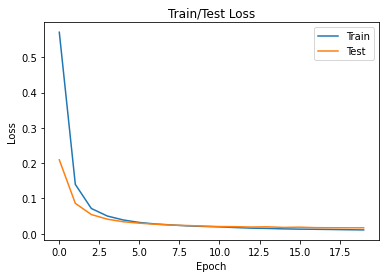

In [ ]:
# Plot
print(train_loss_list)
print(test_loss_list)

plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Test Loss')
plt.legend(['Train', 'Test'])
plt.show()